# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [52]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1, -2, 3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [83]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [90]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [91]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [93]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [182]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

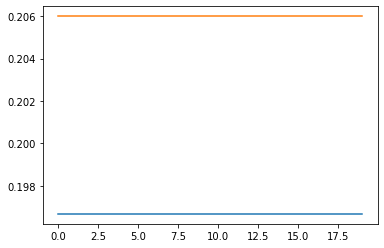

In [100]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [101]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.284906, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242692, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279424, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315797, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242361, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259548, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306860, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263498, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320113, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310367, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314918, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289817, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256856, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247359, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.369704, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [102]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.327203, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280946, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312399, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297599, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293954, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300021, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323295, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317361, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274973, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304328, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254193, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311597, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282063, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277536, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [103]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335830, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.320055, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.313986, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294069, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.284094, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.277865, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.214129, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.237839, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.316008, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.167856, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.731875, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.114886, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.982821, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.123514, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.708389, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.374617, Train acc

Loss: 1.188546, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.580501, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.298824, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.334062, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.151346, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.603832, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.262320, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.159190, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.328048, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.267489, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.186284, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.423161, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.482741, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.525613, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.377793, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.440700, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [146]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.315950, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.260734, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.115864, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1.908583, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.919218, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.781843, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.240342, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 2.030809, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.724831, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.467886, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.867009, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.029513, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 0.046875, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.047815, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.022468, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.008150, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [153]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2, 1e-3]
reg_strength = [1e-2, 5e-3, 1e-3] 
learning_rate_decay = [0.99, 0.9, 0.85]
hidden_layer_size = [128, 256]
momentum = [0.8, 0.9, 0.85]
num_epochs = 20
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

from tqdm import tqdm

best_parameters = (-1, 0, 0, 0, 0, 0 ,0)
for laysize in hidden_layer_size:
    for decay in learning_rate_decay:
        for moment in momentum:
            for reg in reg_strength:
                for rate in learning_rates:
                    print(f'Current parameters are {(batch_size, num_epochs, laysize, decay, moment, reg, rate)}')
                    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = laysize, reg = reg)
                    dataset = Dataset(train_X, train_y, val_X, val_y)
                    trainer = Trainer(model, dataset, MomentumSGD(moment), 
                                      learning_rate=rate, num_epochs=num_epochs, 
                                      batch_size=batch_size, learning_rate_decay=decay)
                    
                    loss_history, train_history, val_history = trainer.fit()
                    print(f'val_accuracy = {val_history[len(val_history)-1]}')
                    if best_parameters[0] < val_history[len(val_history)-1]:
                        best_parameters = (val_history[len(val_history)-1], batch_size, num_epochs, laysize, decay, moment, reg, rate)
    print(f'Best parameters for now are {best_parameters}')

print('best validation accuracy achieved: %f' % best_parameters[0])

Current parameters are (64, 20, 128, 0.99, 0.8, 0.01, 0.1)
val_accuracy = 0.456
Current parameters are (64, 20, 128, 0.99, 0.8, 0.01, 0.01)
val_accuracy = 0.608
Current parameters are (64, 20, 128, 0.99, 0.8, 0.01, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 128, 0.99, 0.8, 0.005, 0.1)
val_accuracy = 0.546
Current parameters are (64, 20, 128, 0.99, 0.8, 0.005, 0.01)
val_accuracy = 0.673
Current parameters are (64, 20, 128, 0.99, 0.8, 0.005, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 128, 0.99, 0.8, 0.001, 0.1)
val_accuracy = 0.624
Current parameters are (64, 20, 128, 0.99, 0.8, 0.001, 0.01)
val_accuracy = 0.7
Current parameters are (64, 20, 128, 0.99, 0.8, 0.001, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 128, 0.99, 0.9, 0.01, 0.1)
val_accuracy = 0.407
Current parameters are (64, 20, 128, 0.99, 0.9, 0.01, 0.01)
val_accuracy = 0.616
Current parameters are (64, 20, 128, 0.99, 0.9, 0.01, 0.001)
val_accuracy = 0.206
Current parameters are (

val_accuracy = 0.489
Current parameters are (64, 20, 256, 0.99, 0.85, 0.01, 0.01)
val_accuracy = 0.626
Current parameters are (64, 20, 256, 0.99, 0.85, 0.01, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 256, 0.99, 0.85, 0.005, 0.1)
val_accuracy = 0.539
Current parameters are (64, 20, 256, 0.99, 0.85, 0.005, 0.01)
val_accuracy = 0.685
Current parameters are (64, 20, 256, 0.99, 0.85, 0.005, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 256, 0.99, 0.85, 0.001, 0.1)
val_accuracy = 0.649
Current parameters are (64, 20, 256, 0.99, 0.85, 0.001, 0.01)
val_accuracy = 0.713
Current parameters are (64, 20, 256, 0.99, 0.85, 0.001, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 256, 0.9, 0.8, 0.01, 0.1)
val_accuracy = 0.64
Current parameters are (64, 20, 256, 0.9, 0.8, 0.01, 0.01)
val_accuracy = 0.483
Current parameters are (64, 20, 256, 0.9, 0.8, 0.01, 0.001)
val_accuracy = 0.206
Current parameters are (64, 20, 256, 0.9, 0.8, 0.005, 0.1)
val_accuracy = 0.6

TypeError: must be real number, not NoneType

In [179]:
print(f"best_parameters: {best_parameters}")
best_classifier = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = best_parameters[3], reg = best_parameters[6])
dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier_trainer = Trainer(best_classifier, dataset, MomentumSGD(best_parameters[5]), learning_rate=best_parameters[7], num_epochs=best_parameters[2], batch_size=best_parameters[1], learning_rate_decay = best_parameters[4])
loss_history, train_history, val_history = best_classifier_trainer.fit()

print('best validation accuracy achieved: %f' % max(val_history))

best_parameters: (0.776, 64, 20, 256, 0.9, 0.8, 0.001, 0.1)
best validation accuracy achieved: 0.774000


Train is red
Validation is blue


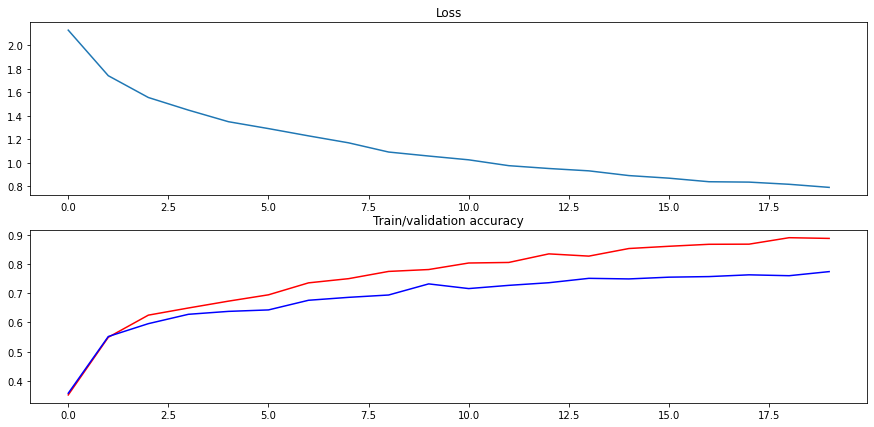

In [180]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history, color='red')
plt.plot(val_history, color='blue')

print('Train is red')
print('Validation is blue')

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [181]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.742000
